In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from base_data_handler import BaseDataHandler
from sklearn.datasets import fetch_california_housing

In [4]:
# Load dataset
housing = fetch_california_housing()

# Convert to DataFrame
df = pd.DataFrame(housing.data, columns=housing.feature_names)

# Add target column (median house value)
df['MedHouseVal'] = housing.target
# Quick check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
handler = BaseDataHandler(df=df)

In [6]:
_ = handler.try_clean_column_names()
handler.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   med_inc        20640 non-null  float64
 1   house_age      20640 non-null  float64
 2   ave_rooms      20640 non-null  float64
 3   ave_bedrms     20640 non-null  float64
 4   population     20640 non-null  float64
 5   ave_occup      20640 non-null  float64
 6   latitude       20640 non-null  float64
 7   longitude      20640 non-null  float64
 8   med_house_val  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


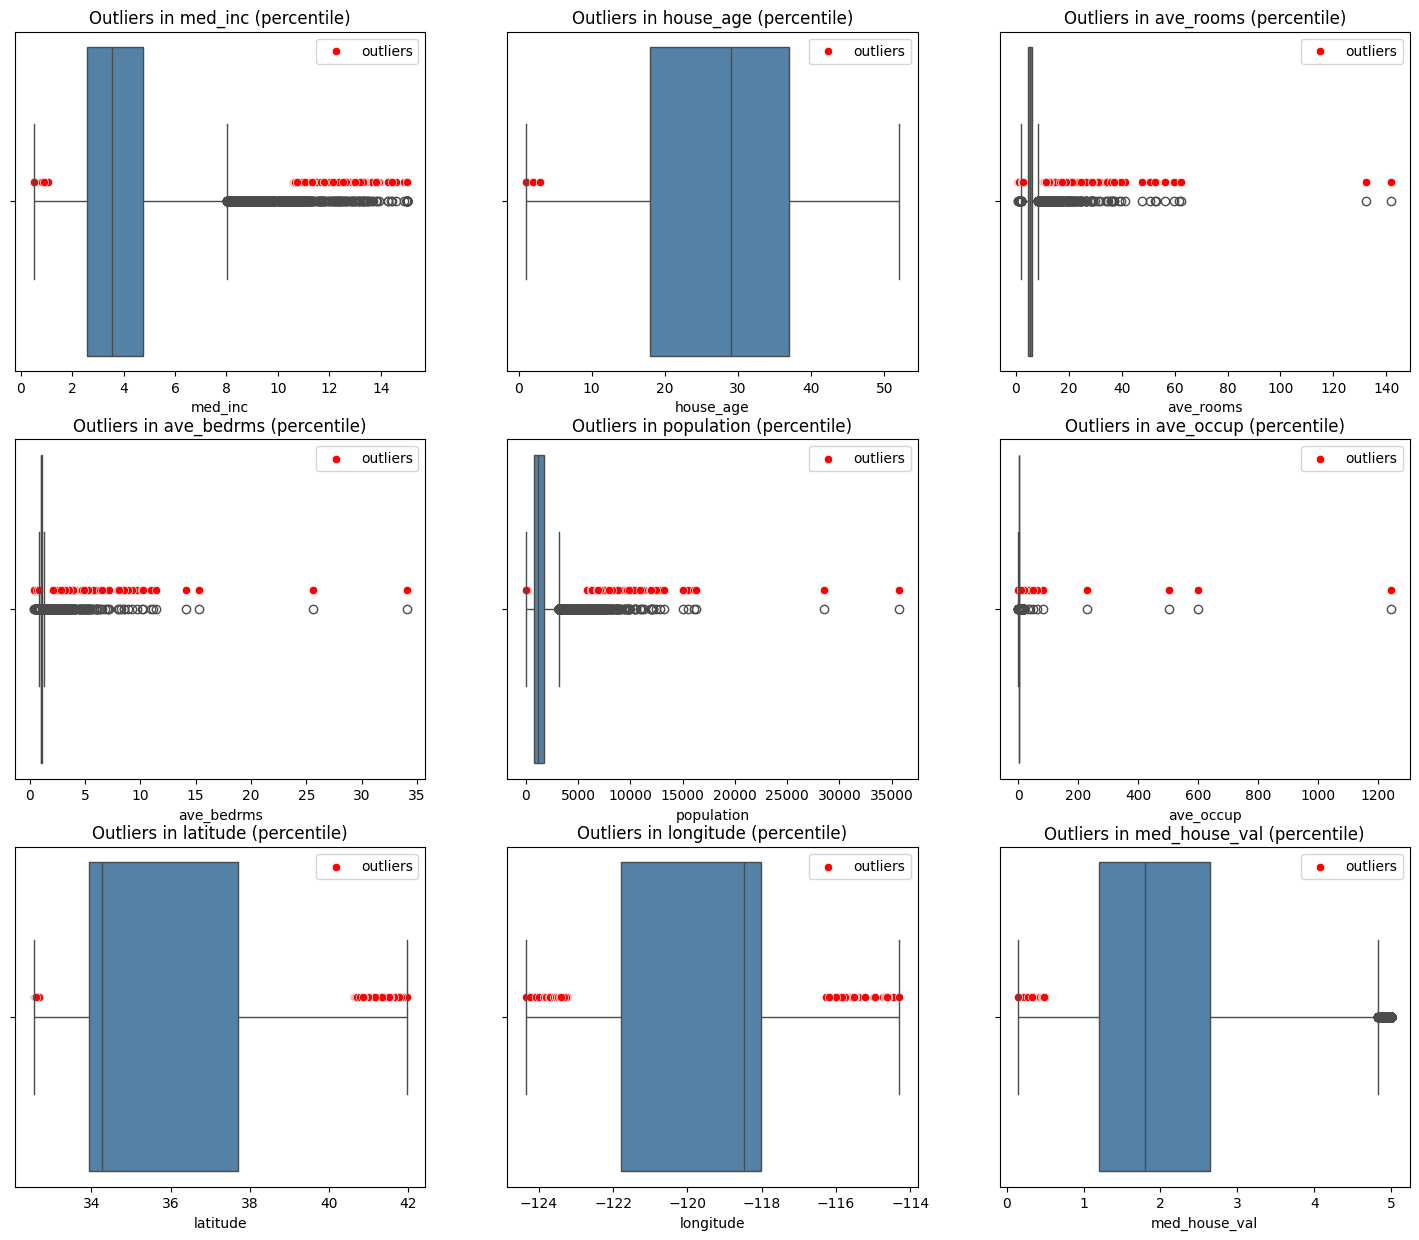

In [7]:
fig, ax = handler.get_outlier_case_study()

In [8]:
mask = handler.get_outliers_df()
handler.df = handler.df[~mask]
handler.df.dropna(inplace=True)
handler.df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16312 entries, 2 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   med_inc        16312 non-null  float64
 1   house_age      16312 non-null  float64
 2   ave_rooms      16312 non-null  float64
 3   ave_bedrms     16312 non-null  float64
 4   population     16312 non-null  float64
 5   ave_occup      16312 non-null  float64
 6   latitude       16312 non-null  float64
 7   longitude      16312 non-null  float64
 8   med_house_val  16312 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


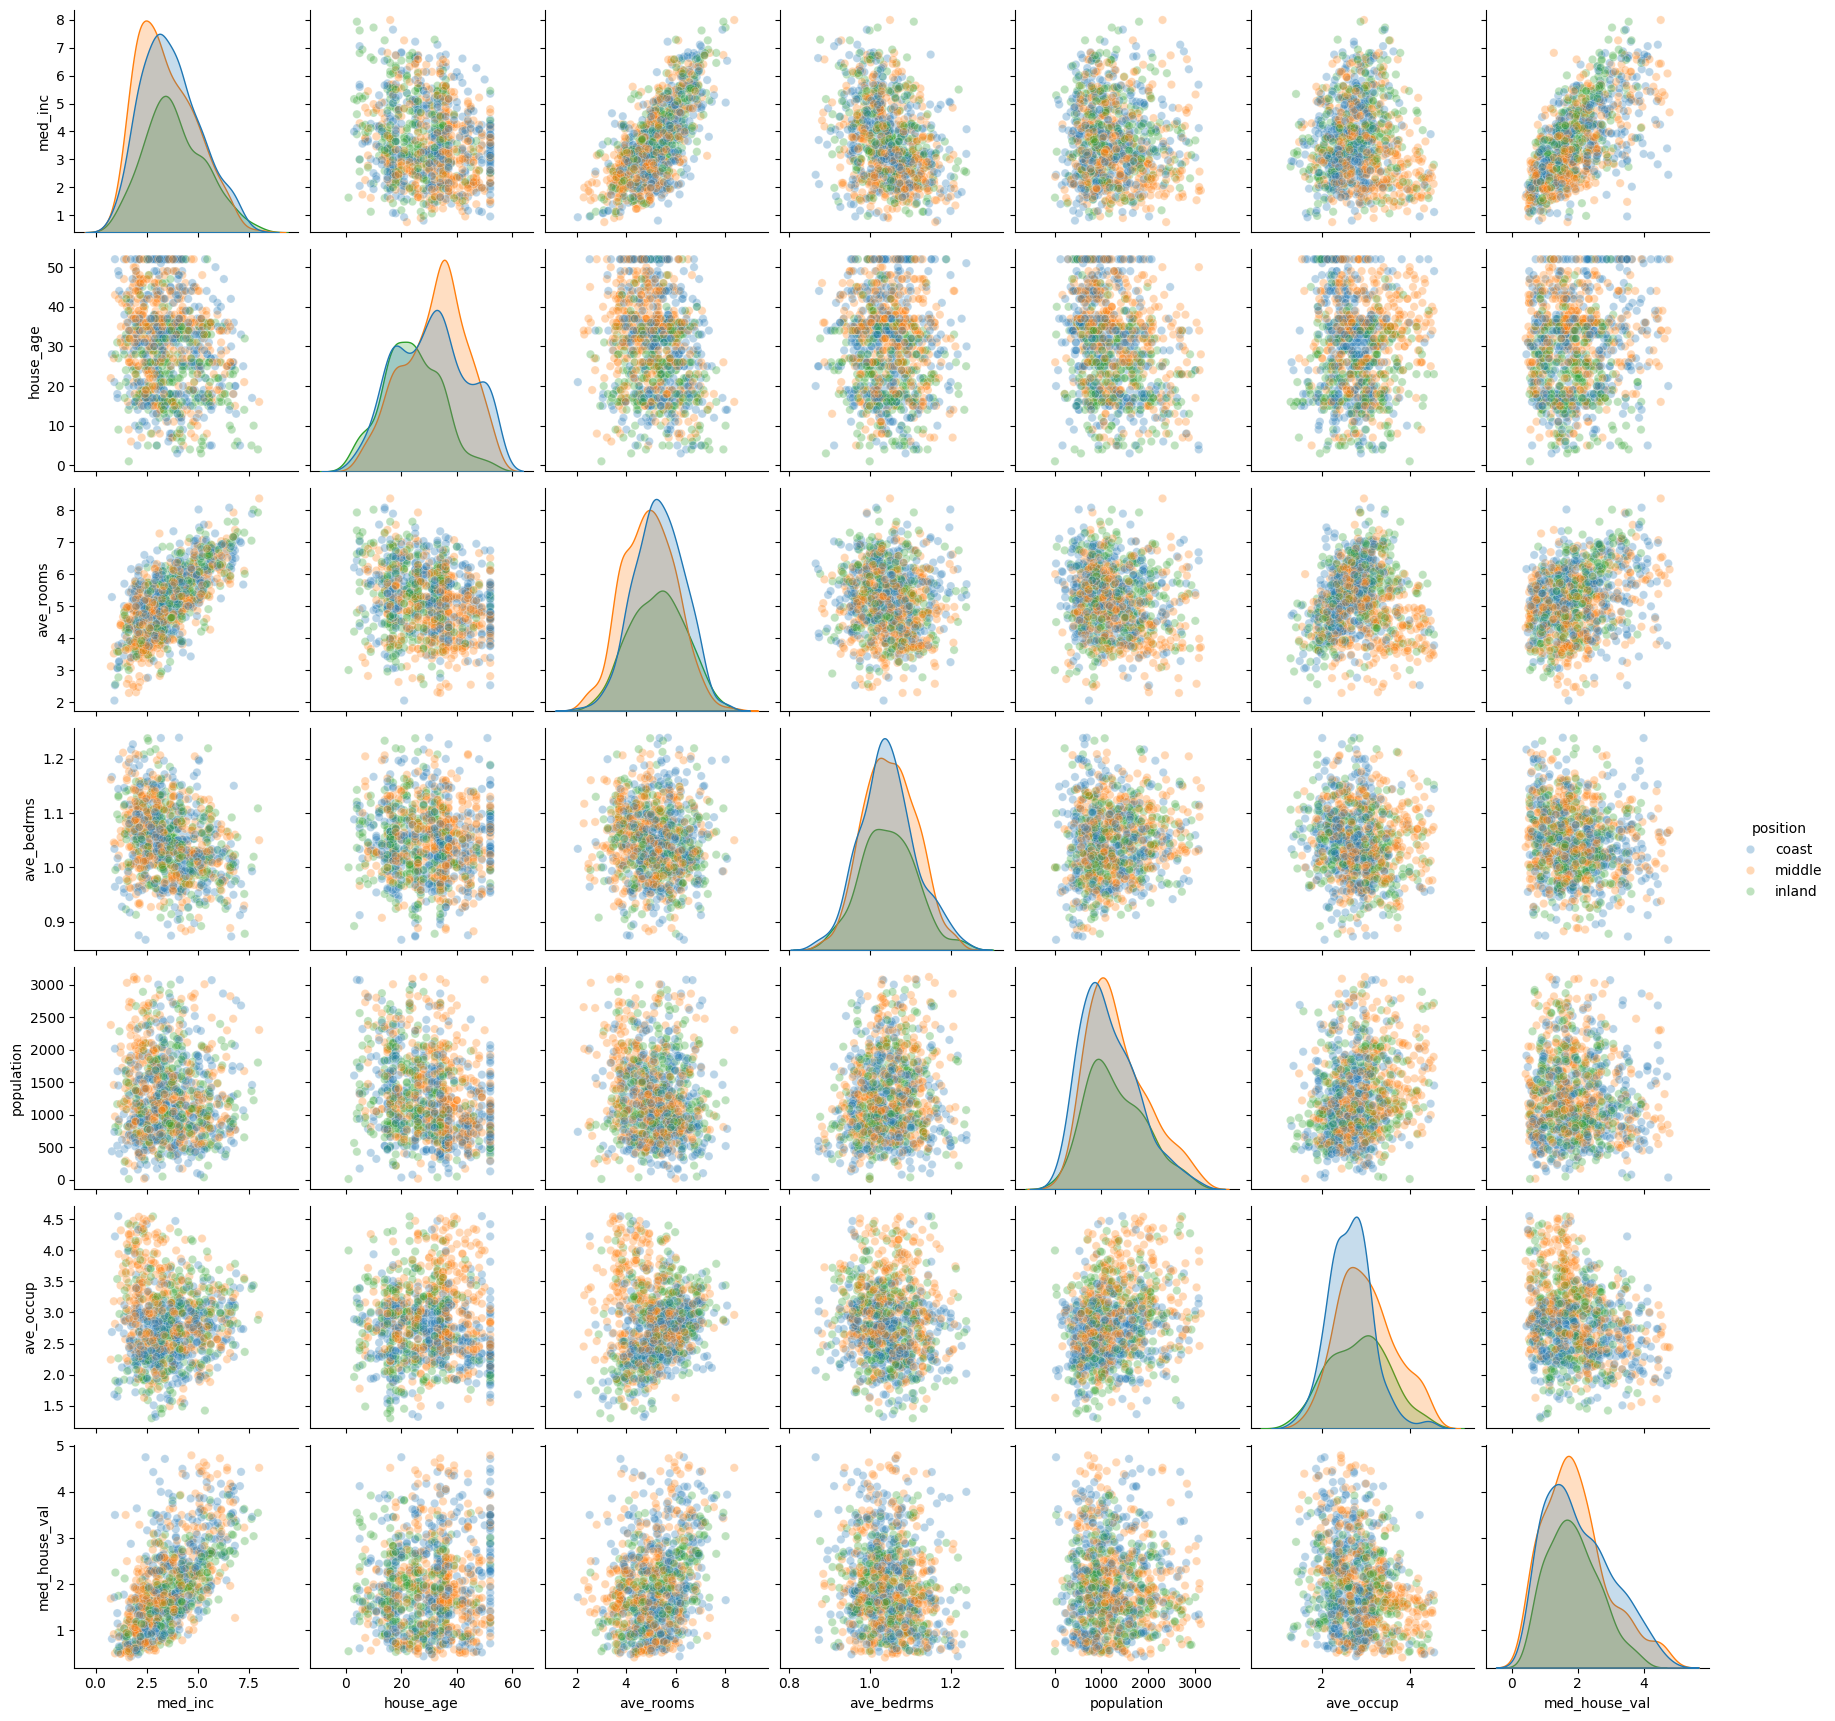

In [9]:
def classify_location(lon):
    if lon <= -121:
        return "coast"
    elif lon <= -118:
        return "middle"
    else:
        return "inland"    

_ = handler.try_add_col(target_col="position", func=lambda row: classify_location(row['longitude']))

sample_df = handler.df.sample(1000, random_state=42)

sns.pairplot(
    sample_df,
    vars=["med_inc", "house_age", "ave_rooms", "ave_bedrms", "population", "ave_occup", "med_house_val"],
    hue="position",
    diag_kind="kde",
    plot_kws={"alpha":0.3}
)
